In [1]:
import json
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from umap import UMAP
import os
import torch
import re
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\bin_l\anaconda3\envs\MIS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"目前使用的設備是: {device}")

目前使用的設備是: cuda


In [3]:
def clean_text(text):
    # 1. 移除網址 (http, https, ftp, www)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # 2. 移除一些社群常見的雜訊 (可選)
    # 例如：移除重複的換行或多餘空格
    text = text.replace('\n', ' ').strip()
    return text

In [15]:
##############
# Read data
##############

platform_name = "threads"
input_file_name = "threads_comments.json"

with open(input_file_name, "r", encoding="utf-8") as f:
    fb_comments_dict = json.load(f)
print(f"成功從{input_file_name}讀取檔案至fb_comments_dict\n")


print()

# 將全部留言存到all_comments
all_comments = []
for artist in fb_comments_dict:
    if artist == '張書偉' or artist == '陳柏霖' or artist == '書偉':
        continue
    all_comments += fb_comments_dict[artist]
    print(artist)
    
print()

# 刪掉url
all_comments_cleaned = [clean_text(str(c)) for c in all_comments if len(clean_text(str(c))) > 2]
print("成功將所有留言存入all_comments_cleaned，並去除留言內的url\n")
print(f"all_comments_cleaned共有{len(all_comments_cleaned)}篇貼文")

成功從threads_comments.json讀取檔案至fb_comments_dict


修杰楷
坤達
小杰
王大陸
阿達
陳零九

成功將所有留言存入all_comments_cleaned，並去除留言內的url

all_comments_cleaned共有1680篇貼文


In [24]:
############
# Settings
############

# 1. 向量化模型 (使用多語言支援)
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 2. 降維模型 (UMAP): 影響分群的精細度
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# 3. 聚類模型 (HDBSCAN): 自動偵測分群
# min_cluster_size: 一個主題最少要有幾則留言 (可根據資料量調整)
min_size = 15
hdbscan_model = HDBSCAN(min_cluster_size=min_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 4. 關鍵字提取 (Vectorizer): 排除停用詞
vectorizer_model = CountVectorizer(stop_words=["的", "了", "在", "是", "我", "https", "com"])

print(f"設定元件完畢{min_size}")

設定元件完畢15


In [25]:
#############
# Training
#############
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(all_comments_cleaned)

2025-12-25 05:35:16,302 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 53/53 [00:01<00:00, 42.09it/s]
2025-12-25 05:35:17,578 - BERTopic - Embedding - Completed ✓
2025-12-25 05:35:17,578 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-25 05:35:21,500 - BERTopic - Dimensionality - Completed ✓
2025-12-25 05:35:21,502 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-25 05:35:21,550 - BERTopic - Cluster - Completed ✓
2025-12-25 05:35:21,553 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-25 05:35:21,604 - BERTopic - Representation - Completed ✓


In [26]:
# 將離群值分配給最相似的主題
new_topics = topic_model.reduce_outliers(all_comments_cleaned, topics)

# 更新模型中的主題標籤
topic_model.update_topics(all_comments_cleaned, topics=new_topics)

100%|██████████| 1/1 [00:00<00:00, 105.24it/s]
2025-12-25 05:35:21,704 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [27]:
###################
# Display Results
###################

# 取得主題清單 (-1 代表雜訊/不屬於任何主題)
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

# 儲存結果
topic_info.to_csv(f"hdbscan_topics_{platform_name}_overlap.csv", index=False, encoding="utf-8-sig")


   Topic  Count                                               Name  \
0     -1    289              -1_每個人都會犯錯_就算真的目睹爸爸上銬_想要以退為進_結果表情洩露一切   
1      0     88                   0_你要自首_他會好好面對_就可以出來了_就是偽造文書和逃避兵役   
2      1     86                          1_沒自首_5月調查閃兵藝人_負責_上有很大的問題   
3      2     90             2_作者_修杰楷怎麼好意思讓老婆出來坦_但認罪的是書偉_他就是造假地中海貧血   
4      3     90                              3_net_ettoday_news_認了   
5      4     70        4_他一個人搞出了滿滿的逃兵大平台_這一切都要感謝王大陸_偶像_不愧是藝人每個都很會演   
6      5     73  5_並以當兵為榮的優質台灣男之外_一堆人還幫他們帶風向_到底幹嘛把自己的未來交到這些逃避責任...   
7      6     69                                  6_查看動態_熱門_張書偉_267   
8      7     56  7_也拒絕這種為逃兵藝人洗白的話術_永遠抵制王大陸_請不要娛樂化他長期勾結犯罪集團詐騙逃兵的...   
9      8     56           8_再然後都忘記當初的牽線人_一定牽扯到了什麼_然後才承認當初的錯誤_最強的身體   

                                      Representation  \
0  [每個人都會犯錯, 就算真的目睹爸爸上銬, 想要以退為進, 結果表情洩露一切, 也是爸爸確實...   
1  [你要自首, 他會好好面對, 就可以出來了, 就是偽造文書和逃避兵役, 套句網友說的, 當然...   
2  [沒自首, 5月調查閃兵藝人, 負責, 上有很大的問題, 逃兵男藝人, 自首了, 為了不助長...   
3  [作

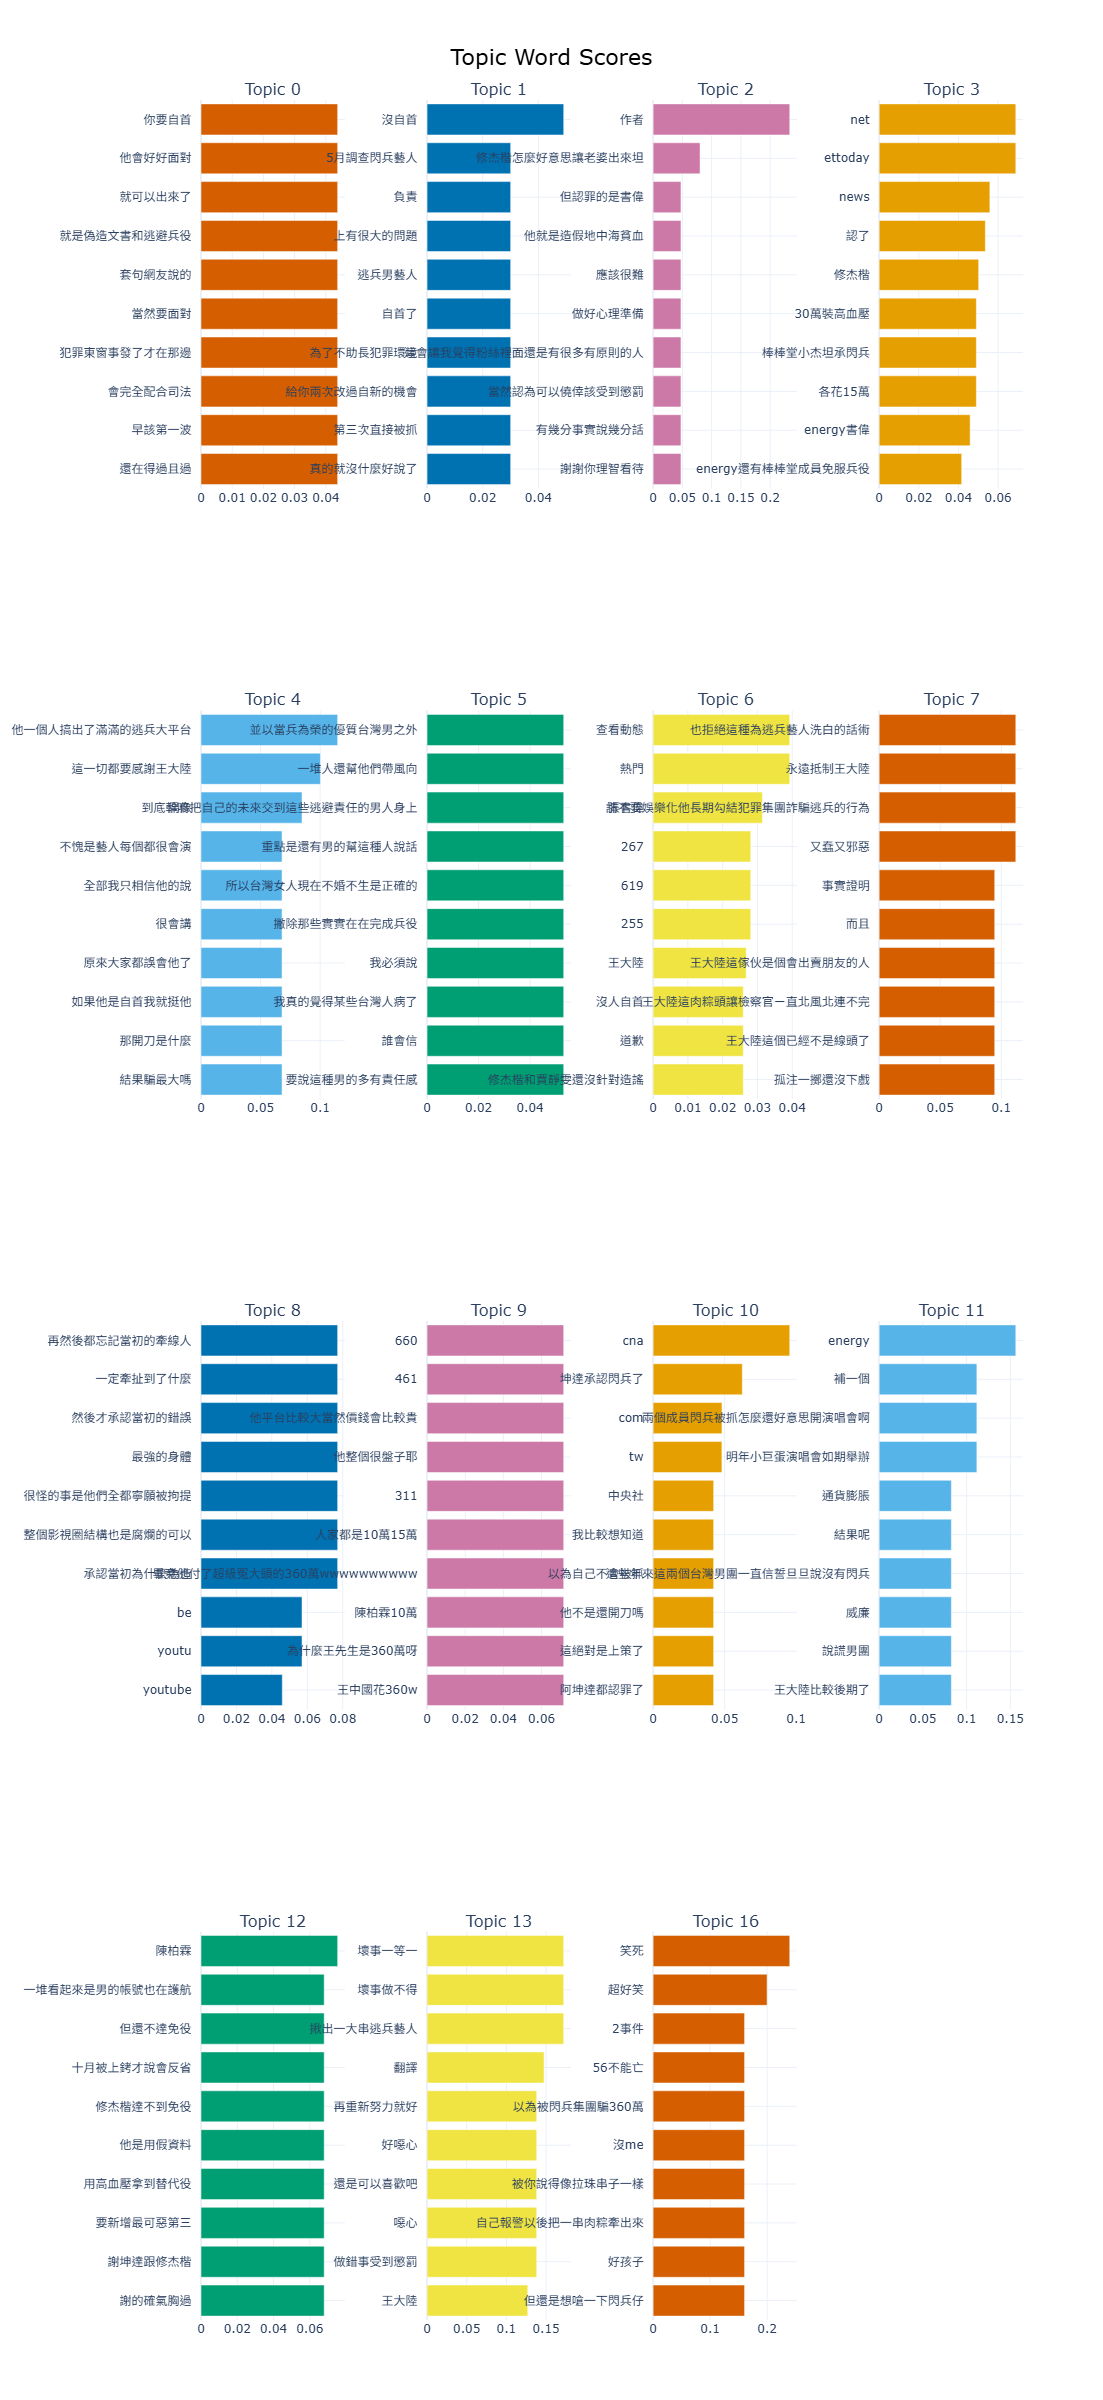

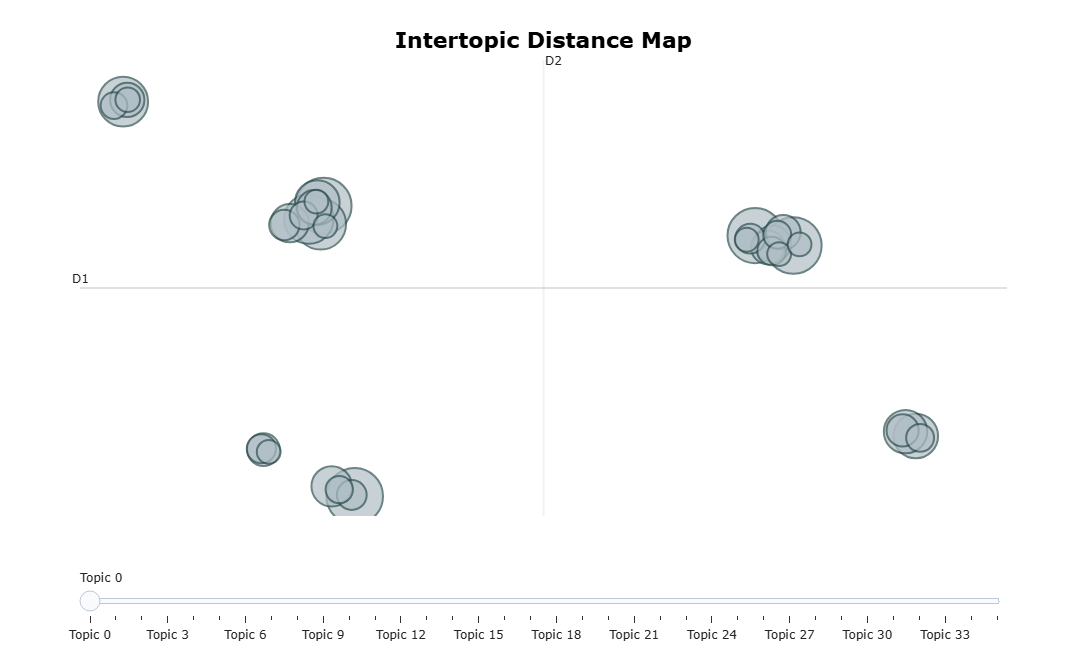

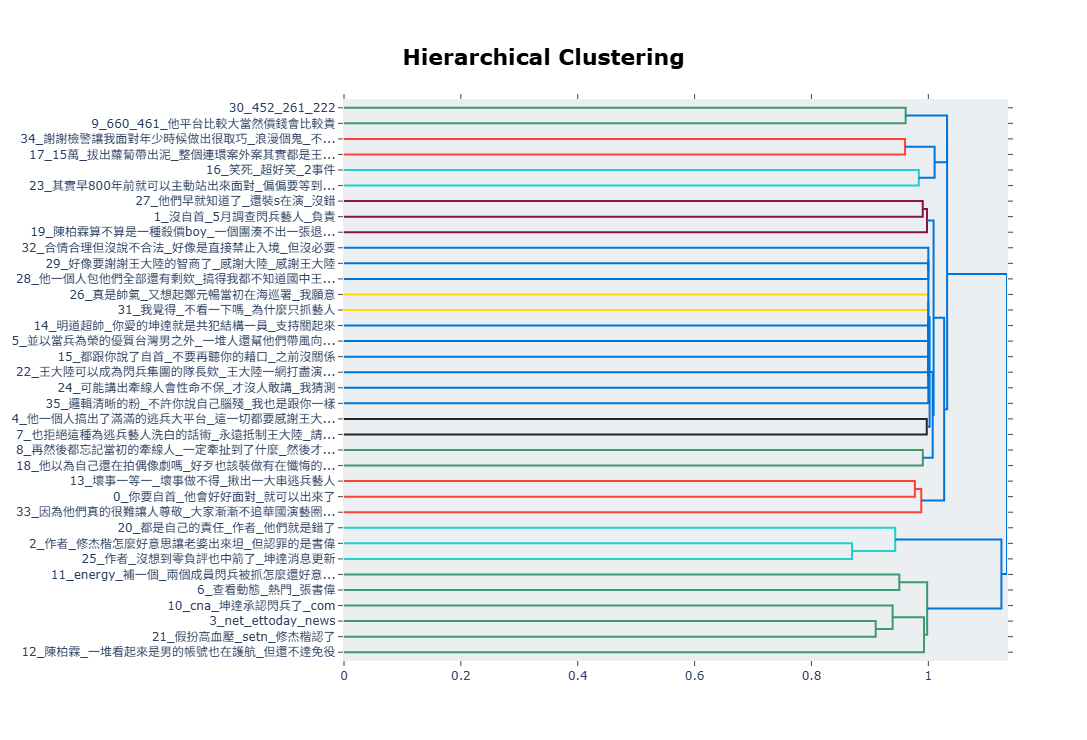

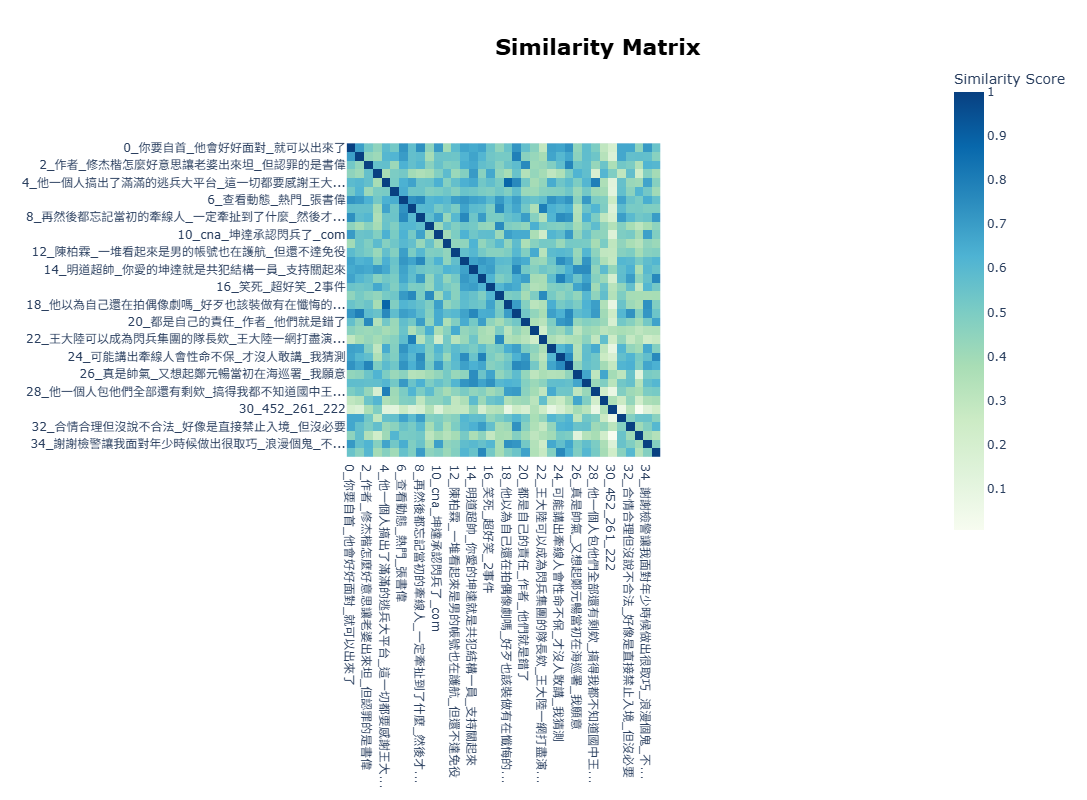

In [29]:
###############
# 圖形化顯示
###############

# top_n_topics: 顯示前幾個主題
# n_words: 每個主題顯示幾個關鍵字
fig1 = topic_model.visualize_barchart(top_n_topics=15, n_words=10, height=600)
fig1.show()

# 儲存為 HTML 檔（可以用瀏覽器開啟，保留互動功能）
fig1.write_html(f"topic_barchart_{platform_name}_overlap.html")

# intertopic distance map
fig2 = topic_model.visualize_topics()
fig2.show()
fig2.write_html(f"topic_distance_map_{platform_name}_overlap.html")

# Hierarchy
fig3 = topic_model.visualize_hierarchy()
fig3.show()
fig3.write_html(f"topic_hierarchy_{platform_name}_overlap.html")

# Heat Map
fig4 = topic_model.visualize_heatmap()
fig4.show()
fig4.write_html(f"topic_heatmap_{platform_name}_overlap.html")